In [1]:
import pandas as pd
import matplotlib
import psycopg2

In [2]:
host="localhost"
port=5432
dbname="hmvl"
username="dirmed"
#pwd="votremotdepasse"

In [8]:
# mise à jour 24/04 : suppression des fichiers en doublon avant l'import en base,
# pour les données du 2/4 on passe de 3,4M à 1,8M de lignes
# l'import est rapide pour une journée, en tout cas de 3M de lignes (20 minutes)
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
sql = "select * from hmvl;"
hmvl = pd.read_sql_query(sql, conn)
conn = None

In [9]:
hmvl["hdt"] = pd.to_datetime(hmvl["hdt"],utc=True)

In [5]:
hmvl.dtypes

id                           int64
horodate_id                 object
hdt            datetime64[ns, UTC]
station                     object
status                      object
voie                        object
vitesse                    float64
longueur                   float64
statuttr                    object
dtype: object

In [5]:
print(hmvl["statuttr"].value_counts())
# a priori on garde les statuts B et @
# pour H que fait-on ? en principe c'est une erreur interne mais les valeurs ont l'air correctes
# de même pour J... et les autres valeurs ne sont pas documentées
# par exemple avec le statuttr J il n'y a aucune ligne avec le status 2
print(hmvl[(hmvl["status"]=="2") & (hmvl["statuttr"]=="J")])
# -> a priori le Status TR n'apporte pas d'info permettant d'éliminer des mesures
hmvl[hmvl["statuttr"]=="H"][:20]


@    959290
B    782871
H     79165
J     63859
          2
I         2
Name: statuttr, dtype: int64
Empty DataFrame
Columns: [id, horodate_id, hdt, station, status, voie, vitesse, longueur, statuttr]
Index: []


,id,horodate_id,hdt,station,status,voie,vitesse,longueur,statuttr
13,2239401,Thu Apr 2 14:49:18 2020,2020-04-02 12:49:18+00:00,M1b,0,None,NaN,NaN,H
26,2239414,Thu Apr 2 14:49:18 2020,2020-04-02 12:49:18+00:00,M1c,0,None,NaN,NaN,H
89,2239477,Thu Apr 2 14:49:18 2020,2020-04-02 12:49:18+00:00,M7O,0,None,NaN,NaN,H
98,2239486,Thu Apr 2 14:49:18 2020,2020-04-02 12:49:18+00:00,M1h,0,None,NaN,NaN,H
111,2239499,Thu Apr 2 14:49:18 2020,2020-04-02 12:49:18+00:00,M1B,0,None,NaN,NaN,H
166,2239554,Thu Apr 2 14:49:18 2020,2020-04-02 12:49:30.510000+00:00,M3x,0,0,94.0,3.7,H
167,2239555,Thu Apr 2 14:49:18 2020,2020-04-02 12:49:31.390000+00:00,M3x,0,0,87.0,4.2,H
168,2239556,Thu Apr 2 14:49:18 2020,2020-04-02 12:49:33.090000+00:00,M3x,0,1,96.0,4.2,H
169,2239557,Thu Apr 2 14:49:18 2020,2020-04-02 12:49:28.240000+00:00,M7j,0,0,87.0,4.0,H
170,2239558,Thu Apr 2 14:49:18 2020,2020-04-02 12:49:28.440000+00:00,M7j,0,1,105.0,4.3,H


In [10]:
hmvl["status"].value_counts()
# une fois éliminé les doublons il semble qu'il n'y ait plus de données avec le status 2

0    841365
Name: status, dtype: int64

In [8]:
print(hmvl[hmvl["status"]=="2"]["longueur"].value_counts())
# n'affiche rien:
# c'est rassurant, quand le status est 2, il n'y a pasde mesures de vitesse ni de longueur
# on peut donc garder les stats de status 2 par station des diagnostics, 
# et on peut les enlever pour les traitements ultérieurs
x=hmvl[hmvl["status"]=="2"]["station"].value_counts()[0:15]
print(x)
print(hmvl["station"].value_counts()[x.keys()])
# on voit que certaines stations M3S, M8Q... n'ont aucune mesure

Series([], Name: longueur, dtype: int64)
Series([], Name: station, dtype: int64)
Series([], Name: station, dtype: int64)


In [9]:
hmvl["hdt"].min() , hmvl["hdt"].max(), hmvl["hdt"].max()-hmvl["hdt"].min()
# on a encore des dates anormales, 26/12/19... 21/02/20....
# a priori on ne doit garder que le mesures de la date du jour, éventuellement les horodates autour de minuit

(Timestamp('2020-04-01 13:31:12+0000', tz='UTC'),
 Timestamp('2020-04-02 21:59:59.340000+0000', tz='UTC'),
 Timedelta('1 days 08:28:47.340000'))

In [11]:
hmvl["hdt"].dt.date.value_counts()

2020-04-02    1760148
2020-04-03      57418
2020-04-01      20348
Name: hdt, dtype: int64

In [11]:
listedates=hmvl["horodate_id"].str[:10]
listedates.value_counts()

2020-04-02    937665
Thu Apr  2    776415
Fri Feb 21     80058
Wed Apr  1     47275
Thu Dec 26      5246
Name: horodate_id, dtype: int64

In [35]:
len(hmvl[pd.isna(hmvl["status"])])+len(hmvl[hmvl["status"]=="0"])-len(hmvl["status"])

0

In [19]:
hmvl2=hmvl[hmvl["status"]=="0"][["id","hdt","station","voie","vitesse","longueur"]]
# en fait hmvl2 correspond aux seuls données VRU car pour les Labocom le status est vide (pd.isna est True)

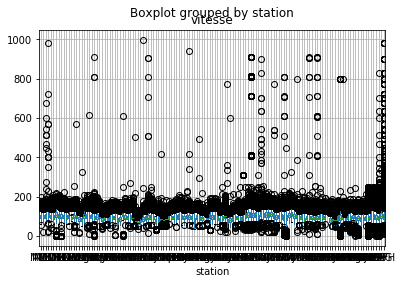

In [36]:
hmvl.boxplot(column=["vitesse"],by="station")
# ça semble raisonnable de prendre 280 (voire 240) comme valeur seuil de vitesse

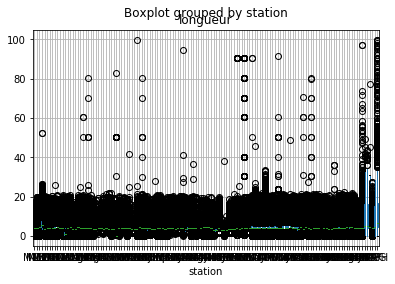

In [37]:
hmvl.boxplot(column=["longueur"],by="station")
# ça semble raisonnable de prendre 25 comme valeur seuil de longueur, 
# mais il y a peut être valeur plus pertinente pour le métier, à cause des Transports Exceptionnels par exemple?
# ou pour voir passer les convois ITER s'ils empruntent le réseau DIRMED?

In [38]:
print(hmvl['voie'].value_counts())
# cette fonction n'affiche pas les valeurs vides mais il y en a (291838)
# cf. hmvl2['voie'].unique()
sum(pd.isna(hmvl2['voie']))

0    686694
2    515413
1    385004
3    118886
4     26448
5      4998
*       227
9       118
8        46
7         6
6         2
Name: voie, dtype: int64


86320

In [16]:
len(hmvl)
# 1,8 M de lignes pour hmvl, dont 0,9 VRU et autant labocom? 
#(peut être parce que les labocom sont sur 24H  et 2 sens?)

1846659

In [17]:
 len(hmvl2)

908994

In [39]:
hmvl.shape

(1846659, 9)

In [50]:
sum(pd.isna(hmvl['voie']))
# 100k sur 1800k mesures n'ont pas de voie dont sont inutilisables?

109019

135

634902

In [45]:
M8i=hmvl2[hmvl2["station"]=="M8i"]
M8i.head(5)

,id,hdt,station,voie,vitesse,longueur
176,101555,2020-04-02 12:49:22.140000+00:00,M8i,2,NaN,NaN
177,101556,2020-04-02 12:49:22.480000+00:00,M8i,0,70.0,4.5
178,101557,2020-04-02 12:49:22.610000+00:00,M8i,1,82.0,5.4
179,101558,2020-04-02 12:49:22.640000+00:00,M8i,2,78.0,4.1
180,101559,2020-04-02 12:49:23.510000+00:00,M8i,1,65.0,4.6


In [46]:
len(M8i["hdt"])
# 16066 mesures dans la journée

16066

In [47]:
idu=hmvl.groupby("hdt")["id"].unique()
# sur 2,8M mesures, seulement 52092 correspondent à une seule horodate

In [14]:
id_hv=hmvl.groupby(["hdt","station","voie"])["id"].unique()
id_hv.apply(len).value_counts()
# sur 1,8M mesures, il y désormais très peu de doublons, qui correspondent aux dates incorrectes, d'ailleurs?
# cf. ci-dessous mesures du 26/12 -> il faudrait donc vérifier dans le fichier (RD - pas possible dans le labocom)
# que l'horodate dans l'en-tête est bien à la date du jour à importer en base

1    1600029
2      64326
4         43
3         14
Name: id, dtype: int64

In [16]:

# lecture des logs pour comprendre d'où viennent les répliques
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
sql = "select * from log_imports;"
logs= pd.read_sql_query(sql, conn)
conn = None

In [12]:
def mesures_répliquées(i):
# afficher les mesures pour une ligne de id_hv
    for x in id_hv.iloc[i]:
        fichier=logs[(logs['firstid']<=x) & (logs['lastid']>=x)].iloc[0]['fichier'][17:]
        print (fichier)
        print (hmvl2[hmvl2["id"]==x][["id","hdt","voie","vitesse","longueur"]])


In [22]:
mesures_répliquées(565)
# après utilisation de duplicates.py pour supprimer les fichiers en doublon :  plus de doublons dans le dataframe

ocom/09_MPH_1.csv
Empty DataFrame
Columns: [id, hdt, voie, vitesse, longueur]
Index: []


In [23]:
id_hv.head()

hdt                               station  voie
2020-04-01 22:00:00.300000+00:00  MPH      2                [3069332]
2020-04-01 22:00:00.890000+00:00  MPG      0                [2731256]
2020-04-01 22:00:01.230000+00:00  MBS      2       [3033582, 3434455]
2020-04-01 22:00:01.380000+00:00  MPB      2                [3222253]
2020-04-01 22:00:02.530000+00:00  MPF      0                [3305511]
Name: id, dtype: object

In [24]:
sansdouble=hmvl2.groupby(["hdt","station","voie"])

In [25]:
len(sansdouble)

776010

In [26]:
len(hmvl2)
# il reste des doublons!

841365

In [28]:
type(sansdouble)
# DataFrameGroupBy type
#sansdouble.groups est un dict de triplets hdt,station,voie

pandas.core.groupby.generic.DataFrameGroupBy

In [33]:
sansdouble.size().sort_values()

hdt                               station  voie
2020-04-02 12:29:22.840000+00:00  M8k      0       1
2020-04-02 13:23:14.640000+00:00  M4m      0       1
2020-04-02 13:23:14.740000+00:00  M3i      0       1
                                  M5f      3       1
2020-04-02 13:23:14.790000+00:00  M7i      0       1
                                                  ..
2020-04-02 06:02:58.810000+00:00  M8O      0       4
2020-04-02 06:10:22.560000+00:00  M8n      1       4
2020-04-02 06:24:00.500000+00:00  M7i      0       4
2020-04-02 06:16:24.210000+00:00  M3j      4       4
2020-04-02 06:12:49.750000+00:00  M8G      0       4
Length: 694818, dtype: int64

In [35]:
sansdouble.get_group(('2020-04-02 06:12:49.750000+00:00','M8G','0'))
# on a encore des doublons, exemple 2 fois les mêmes mesures v,l, 2 fois des mesures différentes?

,id,hdt,station,voie,vitesse,longueur
1576712,3883723,2020-04-02 06:12:49.750000+00:00,M8G,0,77.0,7.7
1589568,3896579,2020-04-02 06:12:49.750000+00:00,M8G,0,120.0,5.5
1700672,4054958,2020-04-02 06:12:49.750000+00:00,M8G,0,77.0,7.7
1713521,4067807,2020-04-02 06:12:49.750000+00:00,M8G,0,120.0,5.5


In [49]:
len(hmvl),len(hmvl2),len(sansdouble)

(1837914, 841365, 776010)

In [41]:
type(hmvl['hdt'])
type(hmvl['hdt'].loc[1])

pandas._libs.tslibs.timestamps.Timestamp

In [38]:
type(hmvl)

pandas.core.frame.DataFrame

In [42]:
hmvl['datetime'] = pd.to_datetime(hmvl['hdt'])
# Set the datetime column as the index
hmvl.index = hmvl['hdt'] 

In [45]:
v6=hmvl['vitesse'].resample('6T').mean() 
qv6=hmvl['vitesse'].resample('6T').count()
l6=hmvl['longueur'].resample('6T').mean()
ql6=hmvl['longueur'].resample('6T').count()
# calcul naïf de l'agrégation 6 minutes
# le débit n'est pas le même selon qu'on prend en compte les vitesses non vides ou les longueurs non vides
# on pourrait facilement renvoyer ça dans un table t6m

In [46]:
v6,qv6,l6,ql6

(hdt
 2020-04-01 22:00:00+00:00     94.267624
 2020-04-01 22:06:00+00:00     95.419825
 2020-04-01 22:12:00+00:00     94.747619
 2020-04-01 22:18:00+00:00     95.798387
 2020-04-01 22:24:00+00:00     94.212851
                                 ...    
 2020-04-03 14:54:00+00:00     98.070136
 2020-04-03 15:00:00+00:00    100.558753
 2020-04-03 15:06:00+00:00    100.552463
 2020-04-03 15:12:00+00:00    100.022936
 2020-04-03 15:18:00+00:00     98.719298
 Freq: 6T, Name: vitesse, Length: 414, dtype: float64,
 hdt
 2020-04-01 22:00:00+00:00    766
 2020-04-01 22:06:00+00:00    686
 2020-04-01 22:12:00+00:00    630
 2020-04-01 22:18:00+00:00    744
 2020-04-01 22:24:00+00:00    747
                             ... 
 2020-04-03 14:54:00+00:00    442
 2020-04-03 15:00:00+00:00    417
 2020-04-03 15:06:00+00:00    467
 2020-04-03 15:12:00+00:00    436
 2020-04-03 15:18:00+00:00    285
 Freq: 6T, Name: vitesse, Length: 414, dtype: int64,
 hdt
 2020-04-01 22:00:00+00:00    11.230949
 2020-04-01 

In [51]:
# conclusion provisoire : faire une procédure pour chaque jour
# 0. vérifier qu'il n'y a pas d'horodate différentes de la date du jour (attention à la timezone de Paris)
# 1. re-tester les doublons, il ne devrait plus y en avoir
# 2. supprimer les valeurs aberrantes de l et v, et les voies, longueur ou vitesse vides
# 3. agréger les données
# PS il faut aussi faire un diagnostic sur le taux de mesures valides par station